In [1]:
import sys
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm
from tsfresh.feature_extraction import extract_features
from multiprocessing import Pool
tqdm.pandas(desc="apply progress")

/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data_dir = "/Users/hidehisa/.kaggle/competitions/plasticc"
train = pd.read_csv(data_dir + "/train_with_cluster.csv")
meta = pd.read_csv(data_dir + "/training_set_metadata.csv")

In [3]:
def basic(d):
    df = d.copy()
    df["flux_ratio_sq"] = np.power(df["flux"] / df["flux_err"], 2)
    df["flux_by_flux_ratio_sq"] = df["flux"] * df["flux_ratio_sq"]

    aggs = {
        'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'detected': ['mean'],
        'flux_ratio_sq': ['sum', 'skew'],
        'flux_by_flux_ratio_sq': ['sum', 'skew'],
    }
    agg_df = df.groupby('object_id').agg(aggs)
    new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    agg_df.columns = new_columns
    agg_df['flux_diff'] = agg_df['flux_max'] - agg_df['flux_min']
    agg_df['flux_dif2'] = (
        agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_mean']
    agg_df['flux_w_mean'] = agg_df['flux_by_flux_ratio_sq_sum'] / agg_df[
        'flux_ratio_sq_sum']
    agg_df['flux_dif3'] = (
        agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_w_mean']
    agg_flux_diff = agg_df.reset_index()[["object_id", "flux_diff"]]
    df2 = pd.merge(df, agg_df, how="left", on="object_id")
    df2["flux_norm"] = df2.flux / df2.flux_diff
    del df2["flux"]
    fcp = {
        'fft_coefficient': [{
            'coeff': 0,
            'attr': 'abs'
        }, {
            'coeff': 1,
            'attr': 'abs'
        }],
        'kurtosis':
        None,
        'skewness':
        None,
        "cid_ce": [{"normalize": True}]
    }
    fcp2 = {
        "fft_coefficient": [{
            "coeff": 0,
            "attr": "abs"
        }, {
            "coeff": 1,
            "attr": "abs"
        }],
        "abs_energy": None,
        "sample_entropy": None
    }
    fcp_flux = {
        "longest_strike_above_mean": None,
        "longest_strike_below_mean": None,
        "mean_change": None,
        "mean_abs_change": None,
        "cid_ce": [{"normalize": True}]
    }
    fcp_flux_by_flux_ratio_sq = {
        "longest_strike_above_mean": None,
        "longest_strike_below_mean": None
    }
    agg_df_ts = extract_features(
        df,
        column_id='object_id',
        column_sort='mjd',
        column_kind='passband',
        column_value='flux',
        default_fc_parameters=fcp,
        n_jobs=6)
    agg_df_ts2 = extract_features(
        df2,
        column_id="object_id",
        column_sort="mjd",
        column_kind="passband",
        column_value="flux_norm",
        default_fc_parameters=fcp2,
        n_jobs=4
    )
    agg_df_flux = extract_features(
        df,
        column_id="object_id",
        column_value="flux",
        default_fc_parameters=fcp_flux,
        n_jobs=4
    )
    agg_df_ffrs = extract_features(
        df,
        column_id="object_id",
        column_value="flux_by_flux_ratio_sq",
        default_fc_parameters=fcp_flux_by_flux_ratio_sq,
        n_jobs=4
    )
    df_det = df[df['detected'] == 1].copy()

    agg_df_mjd = extract_features(
        df_det,
        column_id='object_id',
        column_value='mjd',
        default_fc_parameters={
            'maximum': None,
            'minimum': None
        },
        n_jobs=8)
    agg_df_mjd['mjd_diff_det'] = agg_df_mjd['mjd__maximum'] - agg_df_mjd[
        'mjd__minimum']
    del agg_df_mjd['mjd__maximum'], agg_df_mjd['mjd__minimum']
    agg_df_ts2.columns = pd.Index([e + "_norm" for e in agg_df_ts2.columns])
    agg_df_ts = pd.merge(agg_df_ts, agg_df_mjd, on='id')
    agg_df_ts = pd.merge(agg_df_ts, agg_df_ts2, on="id")
    agg_df_ts = pd.merge(agg_df_ts, agg_df_flux, on="id")
    agg_df_ts = pd.merge(agg_df_ts, agg_df_ffrs, on="id")
    # tsfresh returns a dataframe with an index name='id'
    agg_df_ts.index.rename('object_id', inplace=True)
    agg_df = pd.merge(agg_df, agg_df_ts, on='object_id')
    return agg_df


def cluster_mean_diff(df):
    new_df = df.groupby(["object_id", "cluster"]).agg({
        "flux": ["mean", "max", "min"]
    })
    new_df.columns = pd.Index(
        [e[0] + "_" + e[1] for e in new_df.columns.tolist()])
    new_df["normalized_mean"] = new_df["flux_mean"] / (
        new_df["flux_max"] - new_df["flux_min"])
    new_df.reset_index(inplace=True)
    return new_df.groupby("object_id").agg({"normalized_mean": "std"})


def passband_std_difference(df):
    std_df = df.groupby(["object_id", "cluster", "passband"]).agg({
        "flux": "std"
    }).reset_index().groupby(["object_id",
                              "passband"])["flux"].mean().reset_index()
    std_df_max = std_df.groupby("object_id")["flux"].max()
    std_df_min = std_df.groupby("object_id")["flux"].min()
    return (std_df_max / std_df_min).reset_index()


def num_outliers(df):
    new_df = df.groupby("object_id").agg({"flux": ["mean", "std"]})
    new_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_df.columns])
    new_df["upper_sigma"] = new_df["flux_mean"] + new_df["flux_std"]
    new_df["upper_2sigma"] = new_df["flux_mean"] + 2 * new_df["flux_std"]
    new_df["lower_sigma"] = new_df["flux_mean"] - new_df["flux_std"]
    new_df["lower_2sigma"] = new_df["flux_mean"] - 2 * new_df["flux_std"]
    new_df.drop(["flux_mean", "flux_std"], axis=1, inplace=True)
    new_df = pd.merge(df, new_df, how="left", on="object_id")
    new_df["outside_sigma"] = (
        (new_df["flux"] > new_df["upper_sigma"]) |
        (new_df["flux"] < new_df["lower_sigma"])).astype(int)
    new_df["outside_2sigma"] = (
        (new_df["flux"] > new_df["upper_2sigma"]) |
        (new_df["flux"] < new_df["lower_2sigma"])).astype(int)

    return_df = new_df.groupby("object_id").agg({
        "outside_sigma": "sum",
        "outside_2sigma": "sum"
    })
    return_df.reset_index(inplace=True)
    return return_df

In [4]:
def haversine_plus(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees) from 
    #https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    #Convert decimal degrees to Radians:
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    dlat = np.subtract(lat2, lat1)

    a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),  
                          np.multiply(np.cos(lat1), 
                                      np.multiply(np.cos(lat2), 
                                                  np.power(np.sin(np.divide(dlon, 2)), 2))))
    
    haversine = np.multiply(2, np.arcsin(np.sqrt(a)))
    return {
        'haversine': haversine, 
        'latlon1': np.subtract(np.multiply(lon1, lat1), np.multiply(lon2, lat2)), 
   }

In [5]:
def process_meta(meta_df):
    meta_dict = dict()
    # distance
    meta_dict.update(haversine_plus(meta_df['ra'].values, meta_df['decl'].values, 
                   meta_df['gal_l'].values, meta_df['gal_b'].values))
    #
    meta_dict['hostgal_photoz_certain'] = np.multiply(
            meta_df['hostgal_photoz'].values, 
             np.exp(meta_df['hostgal_photoz_err'].values))
    
    meta_df = pd.concat([meta_df, pd.DataFrame(meta_dict, index=meta_df.index)], axis=1)
    return meta_df


def add_rank_bottom_and_top(df, feature_name):
    objid = ["object_id"]
    columns = [f"{i}{feature_name}" for i in range(6)]
    partial = df[objid+columns]
    partial_values = partial.melt(id_vars=objid, value_vars=columns).sort_values(["object_id", "value"])
    
    top_and_bottom = partial_values.groupby("object_id").agg({
        "variable": ["first", "last"]
    })
    top_and_bottom.columns = ["top"+feature_name, "bottom"+feature_name]
    for i, n in zip(["0", "1", "2", "3", "4", "5"], columns):
        top_and_bottom = top_and_bottom.replace(n, i)
    top_and_bottom = top_and_bottom.astype(int)
    return top_and_bottom

In [6]:
def get_full(df, meta):
    agg_basic = basic(df)
    cl_mean_diff = cluster_mean_diff(df)
    ps_std_diff = passband_std_difference(df)
    num_out = num_outliers(df)

    full = pd.merge(agg_basic, cl_mean_diff, how="left", on="object_id")
    full = pd.merge(full, ps_std_diff, how="left", on="object_id")
    full = pd.merge(full, num_out, how="left", on="object_id")
    meta = process_meta(meta)
    full = pd.merge(full, meta, how="left", on="object_id")
    if "target" in full.columns:
        full.drop("target", axis=1, inplace=True)
    return full


def train_data(df, meta):
    full = get_full(df, meta)
    y = meta.target
    classes = sorted(y.unique())
    class_weight = {c: 1 for c in classes}
    
    base_name = "flux_norm_fft_"
    for i in range(5):
        for j in range(1, 6):
            if j > i:
                full[f"{base_name}{j}_by_{i}"] = full[f"{j}__fft_coefficient__coeff_0__attr_\"abs\"_norm"] / \
                    full[f"{i}__fft_coefficient__coeff_0__attr_\"abs\"_norm"]
    base_name = "abs_energy_"
    for i in range(5):
        for j in range(1, 6):
            if j > i:
                full[f"{base_name}{j}_by_{i}"] = full[f"{j}__abs_energy_norm"] / full[f"{i}__abs_energy_norm"]
    
    abs_energy = add_rank_bottom_and_top(full, "__abs_energy_norm")
    # fft_coeff = add_rank_bottom_and_top(full, "__kurtosis")
    full = pd.merge(full, abs_energy, how="left", on="object_id")
    # full = pd.merge(full, fft_coeff, how="left", on="object_id")
    for c in [64, 15]:
        class_weight[c] = 2
    oof_df = full[["object_id"]]
    del full['object_id'], full['distmod'], full['hostgal_specz']
    del full['ra'], full['decl'], full['gal_l'], full['gal_b'], full['ddf']
    return full, y, classes, class_weight, oof_df

In [7]:
%%time
full, y, classes, class_weight, oof_df = train_data(train, meta)

Feature Extraction: 100%|██████████| 40/40 [00:00<00:00, 65.76it/s]


CPU times: user 36.7 s, sys: 3.42 s, total: 40.1 s
Wall time: 51.9 s


In [8]:
train_mean = full.mean(axis=0)
full.fillna(0, inplace=True)

In [9]:
full.head()

,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,...,abs_energy_4_by_1,abs_energy_5_by_1,abs_energy_3_by_2,abs_energy_4_by_2,abs_energy_5_by_2,abs_energy_4_by_3,abs_energy_5_by_3,abs_energy_5_by_4,top__abs_energy_norm,bottom__abs_energy_norm
0,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,3.835268,...,0.172018,0.170629,0.565249,0.391823,0.388660,0.693187,0.687591,0.991927,0,1
1,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,...,1.242954,1.591095,1.255009,1.233652,1.579187,0.982983,1.258308,1.280091,1,0
2,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,...,39.870035,59.300528,2.114629,3.561973,5.297886,1.684443,2.505349,1.487346,1,5
3,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,2.555576,1.819875,...,1.794075,1.105754,1.283626,1.135921,0.700110,0.884931,0.545416,0.616337,0,3
4,-16.543753,143.600189,7.145702,1.141288,20.051722,4.406298,0.695277,11.383690,2.753004,2.214854,...,9.380549,5.696489,1.452328,1.463756,0.888889,1.007869,0.612044,0.607266,0,4


In [11]:
full.columns[:60]

Index(['flux_min', 'flux_max', 'flux_mean', 'flux_median', 'flux_std',
       'flux_skew', 'flux_err_min', 'flux_err_max', 'flux_err_mean',
       'flux_err_median', 'flux_err_std', 'flux_err_skew', 'detected_mean',
       'flux_ratio_sq_sum', 'flux_ratio_sq_skew', 'flux_by_flux_ratio_sq_sum',
       'flux_by_flux_ratio_sq_skew', 'flux_diff', 'flux_dif2', 'flux_w_mean',
       'flux_dif3', '0__cid_ce__normalize_True',
       '0__fft_coefficient__coeff_0__attr_"abs"',
       '0__fft_coefficient__coeff_1__attr_"abs"', '0__kurtosis', '0__skewness',
       '1__cid_ce__normalize_True', '1__fft_coefficient__coeff_0__attr_"abs"',
       '1__fft_coefficient__coeff_1__attr_"abs"', '1__kurtosis', '1__skewness',
       '2__cid_ce__normalize_True', '2__fft_coefficient__coeff_0__attr_"abs"',
       '2__fft_coefficient__coeff_1__attr_"abs"', '2__kurtosis', '2__skewness',
       '3__cid_ce__normalize_True', '3__fft_coefficient__coeff_0__attr_"abs"',
       '3__fft_coefficient__coeff_1__attr_"abs"', '

In [12]:
full.columns[60:]

Index(['2__abs_energy_norm', '2__fft_coefficient__coeff_0__attr_"abs"_norm',
       '2__fft_coefficient__coeff_1__attr_"abs"_norm',
       '2__sample_entropy_norm', '3__abs_energy_norm',
       '3__fft_coefficient__coeff_0__attr_"abs"_norm',
       '3__fft_coefficient__coeff_1__attr_"abs"_norm',
       '3__sample_entropy_norm', '4__abs_energy_norm',
       '4__fft_coefficient__coeff_0__attr_"abs"_norm',
       '4__fft_coefficient__coeff_1__attr_"abs"_norm',
       '4__sample_entropy_norm', '5__abs_energy_norm',
       '5__fft_coefficient__coeff_0__attr_"abs"_norm',
       '5__fft_coefficient__coeff_1__attr_"abs"_norm',
       '5__sample_entropy_norm', 'flux__cid_ce__normalize_True',
       'flux__longest_strike_above_mean', 'flux__longest_strike_below_mean',
       'flux__mean_abs_change', 'flux__mean_change',
       'flux_by_flux_ratio_sq__longest_strike_above_mean',
       'flux_by_flux_ratio_sq__longest_strike_below_mean', 'normalized_mean',
       'flux', 'outside_sigma', 'outside_

In [47]:
def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {
        6: 1,
        15: 2,
        16: 1,
        42: 1,
        52: 1,
        53: 1,
        62: 1,
        64: 2,
        65: 1,
        67: 1,
        88: 1,
        90: 1,
        92: 1,
        95: 1
    }
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array(
        [class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = -np.sum(y_w) / np.sum(class_arr)
    return loss


def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {
        6: 1,
        15: 2,
        16: 1,
        42: 1,
        52: 1,
        53: 1,
        62: 1,
        64: 2,
        65: 1,
        67: 1,
        88: 1,
        90: 1,
        92: 1,
        95: 1
    }
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array(
        [class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = -np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

In [48]:
def save_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(8, 12))
    sns.barplot(
        x='gain',
        y='feature',
        data=importances_.sort_values('mean_gain', ascending=False)[:300])
    plt.tight_layout()
    plt.savefig('importances_11.png')


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def save_cm(y, oof_preds, path):
    unique_y = np.unique(y)
    class_map = dict()
    for i, val in enumerate(unique_y):
        class_map[val] = i

    y_map = np.zeros((y.shape[0], ))
    y_map = np.array([class_map[val] for val in y])

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds, axis=-1))
    np.set_printoptions(precision=2)

    sample_sub = pd.read_csv(path)
    class_names = list(sample_sub.columns[1:-1])
    del sample_sub

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(12, 12))
    plot_confusion_matrix(
        cnf_matrix,
        classes=class_names,
        normalize=True,
        title='Confusion matrix')
    plt.savefig("confusion_matrix_11.png")

In [79]:
folds = StratifiedKFold(n_splits=7, shuffle=True, random_state=7)
clfs = []
importances = pd.DataFrame()

lgb_params = {
    'device': 'cpu', 
    'objective': 'multiclass', 
    'num_class': 14, 
    'boosting_type': 'gbdt', 
    'n_jobs': -1, 
    'max_depth': 7, 
    'n_estimators': 500, 
    'subsample_freq': 2, 
    'subsample_for_bin': 5000, 
    'min_data_per_group': 100, 
    'max_cat_to_onehot': 4, 
    'cat_l2': 1.0, 
    'cat_smooth': 59.5, 
    'max_cat_threshold': 32, 
    'metric_freq': 10, 
    'verbosity': -1, 
    'metric': 'multi_logloss', 
    'xgboost_dart_mode': False, 
    'uniform_drop': False, 
    'colsample_bytree': 0.5, 
    'drop_rate': 0.173, 
    'learning_rate': 0.0267, 
    'max_drop': 5, 
    'min_child_samples': 10, 
    'min_child_weight': 100.0, 
    'min_split_gain': 0.1, 
    'num_leaves': 7, 
    'reg_alpha': 0.1, 
    'reg_lambda': 0.00023, 
    'skip_drop': 0.44, 
    'subsample': 0.75
}

# Compute weights
w = y.value_counts()
weights = {i: np.sum(w) / w[i] for i in w.index}
oof_preds = np.zeros((len(full), np.unique(y).shape[0]))

for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    trn_x, trn_y = full.iloc[trn_], y.iloc[trn_]
    val_x, val_y = full.iloc[val_], y.iloc[val_]

    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        trn_x,
        trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=100,
        early_stopping_rounds=50,
        sample_weight=trn_y.map(weights),
        categorical_feature=["top__abs_energy_norm", "bottom__abs_energy_norm"]
    )
    oof_preds[val_, :] = clf.predict_proba(
        val_x, num_iteration=clf.best_iteration_)
    print(multi_weighted_logloss(val_y, oof_preds[val_, :]))

    imp_df = pd.DataFrame()
    imp_df['feature'] = full.columns
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)

    clfs.append(clf)

print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(
    y_true=y, y_preds=oof_preds))

/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bottom__abs_energy_norm', 'top__abs_energy_norm']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bottom__abs_energy_norm', 'top__abs_energy_norm']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.702866	training's wloss: 0.694604	valid_1's multi_logloss: 1.05064	valid_1's wloss: 0.84876
[200]	training's multi_logloss: 0.443529	training's wloss: 0.433333	valid_1's multi_logloss: 0.810002	valid_1's wloss: 0.63801
[300]	training's multi_logloss: 0.341893	training's wloss: 0.331024	valid_1's multi_logloss: 0.726916	valid_1's wloss: 0.584434
[400]	training's multi_logloss: 0.283273	training's wloss: 0.272402	valid_1's multi_logloss: 0.684607	valid_1's wloss: 0.57353
[500]	training's multi_logloss: 0.241774	training's wloss: 0.231376	valid_1's multi_logloss: 0.6574	valid_1's wloss: 0.571549
Did not meet early stopping. Best iteration is:
[500]	training's multi_logloss: 0.241774	training's wloss: 0.231376	valid_1's multi_logloss: 0.6574	valid_1's wloss: 0.571549
0.5715490897981073
Training until validation scores don't improve for 50 rounds.


/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bottom__abs_energy_norm', 'top__abs_energy_norm']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bottom__abs_energy_norm', 'top__abs_energy_norm']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[100]	training's multi_logloss: 0.706857	training's wloss: 0.698018	valid_1's multi_logloss: 1.02128	valid_1's wloss: 0.828915
[200]	training's multi_logloss: 0.446526	training's wloss: 0.435748	valid_1's multi_logloss: 0.78797	valid_1's wloss: 0.619353
[300]	training's multi_logloss: 0.344217	training's wloss: 0.332663	valid_1's multi_logloss: 0.70609	valid_1's wloss: 0.564879
[400]	training's multi_logloss: 0.285341	training's wloss: 0.273962	valid_1's multi_logloss: 0.665419	valid_1's wloss: 0.55242
[500]	training's multi_logloss: 0.243889	training's wloss: 0.232882	valid_1's multi_logloss: 0.637338	valid_1's wloss: 0.548724
Did not meet early stopping. Best iteration is:
[500]	training's multi_logloss: 0.243889	training's wloss: 0.232882	valid_1's multi_logloss: 0.637338	valid_1's wloss: 0.548724
0.5487240646419689
Training until validation scores don't improve for 50 rounds.


/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bottom__abs_energy_norm', 'top__abs_energy_norm']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bottom__abs_energy_norm', 'top__abs_energy_norm']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[100]	training's multi_logloss: 0.696883	training's wloss: 0.688073	valid_1's multi_logloss: 1.04428	valid_1's wloss: 0.954808
[200]	training's multi_logloss: 0.439289	training's wloss: 0.428297	valid_1's multi_logloss: 0.813234	valid_1's wloss: 0.760111
[300]	training's multi_logloss: 0.338275	training's wloss: 0.326775	valid_1's multi_logloss: 0.732248	valid_1's wloss: 0.711179
[400]	training's multi_logloss: 0.28129	training's wloss: 0.270089	valid_1's multi_logloss: 0.692117	valid_1's wloss: 0.700024
Early stopping, best iteration is:
[384]	training's multi_logloss: 0.289011	training's wloss: 0.277784	valid_1's multi_logloss: 0.69642	valid_1's wloss: 0.699602
0.6996020298305691


/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bottom__abs_energy_norm', 'top__abs_energy_norm']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bottom__abs_energy_norm', 'top__abs_energy_norm']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.702877	training's wloss: 0.697514	valid_1's multi_logloss: 1.02781	valid_1's wloss: 0.822674
[200]	training's multi_logloss: 0.444702	training's wloss: 0.436556	valid_1's multi_logloss: 0.799352	valid_1's wloss: 0.608866
[300]	training's multi_logloss: 0.342421	training's wloss: 0.332891	valid_1's multi_logloss: 0.718605	valid_1's wloss: 0.554969
[400]	training's multi_logloss: 0.283848	training's wloss: 0.274268	valid_1's multi_logloss: 0.677367	valid_1's wloss: 0.540028
[500]	training's multi_logloss: 0.242468	training's wloss: 0.233192	valid_1's multi_logloss: 0.649657	valid_1's wloss: 0.537171
Did not meet early stopping. Best iteration is:
[500]	training's multi_logloss: 0.242468	training's wloss: 0.233192	valid_1's multi_logloss: 0.649657	valid_1's wloss: 0.537171
0.5371705847627964
Training until validation scores don't improve for 50 rounds.


/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bottom__abs_energy_norm', 'top__abs_energy_norm']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bottom__abs_energy_norm', 'top__abs_energy_norm']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[100]	training's multi_logloss: 0.702676	training's wloss: 0.6962	valid_1's multi_logloss: 1.04762	valid_1's wloss: 0.861513
[200]	training's multi_logloss: 0.441923	training's wloss: 0.43282	valid_1's multi_logloss: 0.819845	valid_1's wloss: 0.659606
[300]	training's multi_logloss: 0.339733	training's wloss: 0.329564	valid_1's multi_logloss: 0.736472	valid_1's wloss: 0.608582
[400]	training's multi_logloss: 0.281885	training's wloss: 0.271571	valid_1's multi_logloss: 0.694645	valid_1's wloss: 0.599447
[500]	training's multi_logloss: 0.240831	training's wloss: 0.230748	valid_1's multi_logloss: 0.666408	valid_1's wloss: 0.595891
Did not meet early stopping. Best iteration is:
[500]	training's multi_logloss: 0.240831	training's wloss: 0.230748	valid_1's multi_logloss: 0.666408	valid_1's wloss: 0.595891
0.5958906311207632
Training until validation scores don't improve for 50 rounds.


/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bottom__abs_energy_norm', 'top__abs_energy_norm']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bottom__abs_energy_norm', 'top__abs_energy_norm']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[100]	training's multi_logloss: 0.700998	training's wloss: 0.693105	valid_1's multi_logloss: 1.03562	valid_1's wloss: 0.873011
[200]	training's multi_logloss: 0.442724	training's wloss: 0.432913	valid_1's multi_logloss: 0.800916	valid_1's wloss: 0.663783
[300]	training's multi_logloss: 0.340888	training's wloss: 0.330289	valid_1's multi_logloss: 0.718234	valid_1's wloss: 0.613226
[400]	training's multi_logloss: 0.282953	training's wloss: 0.272583	valid_1's multi_logloss: 0.677391	valid_1's wloss: 0.603601
[500]	training's multi_logloss: 0.241891	training's wloss: 0.231867	valid_1's multi_logloss: 0.651601	valid_1's wloss: 0.605725
Did not meet early stopping. Best iteration is:
[500]	training's multi_logloss: 0.241891	training's wloss: 0.231867	valid_1's multi_logloss: 0.651601	valid_1's wloss: 0.605725
0.6057254940991329
Training until validation scores don't improve for 50 rounds.


/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bottom__abs_energy_norm', 'top__abs_energy_norm']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bottom__abs_energy_norm', 'top__abs_energy_norm']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[100]	training's multi_logloss: 0.69941	training's wloss: 0.690282	valid_1's multi_logloss: 1.05182	valid_1's wloss: 0.904429
[200]	training's multi_logloss: 0.442023	training's wloss: 0.431292	valid_1's multi_logloss: 0.824064	valid_1's wloss: 0.711669
[300]	training's multi_logloss: 0.340308	training's wloss: 0.329277	valid_1's multi_logloss: 0.74194	valid_1's wloss: 0.672879
[400]	training's multi_logloss: 0.282017	training's wloss: 0.271178	valid_1's multi_logloss: 0.697723	valid_1's wloss: 0.654653
[500]	training's multi_logloss: 0.241591	training's wloss: 0.23117	valid_1's multi_logloss: 0.668341	valid_1's wloss: 0.647907
Did not meet early stopping. Best iteration is:
[500]	training's multi_logloss: 0.241591	training's wloss: 0.23117	valid_1's multi_logloss: 0.668341	valid_1's wloss: 0.647907
0.6479068761435647
MULTI WEIGHTED LOG LOSS : 0.60017 


/Users/hidehisa/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Normalized confusion matrix


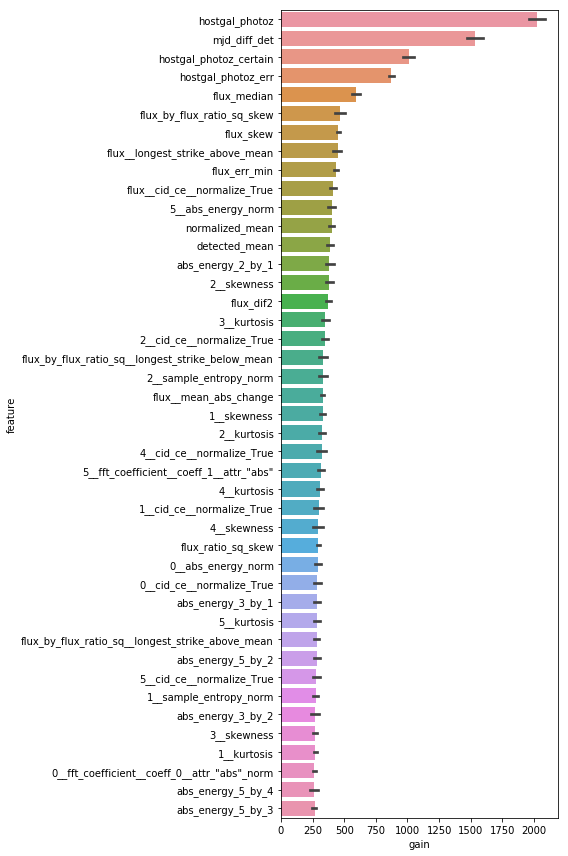

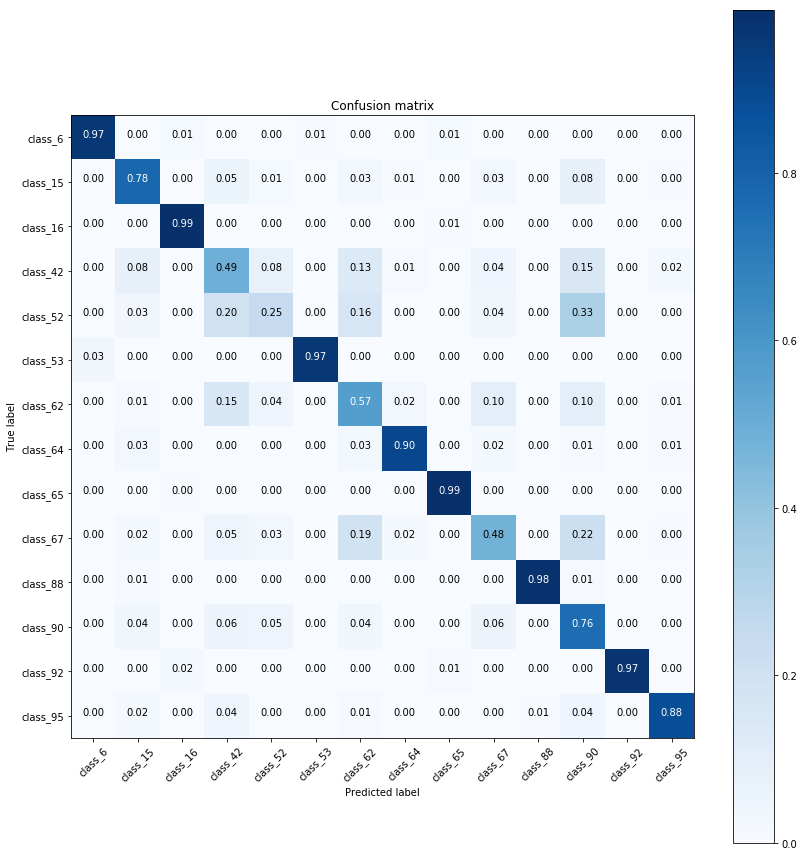

In [50]:
save_importances(importances_=importances)
save_cm(y, oof_preds, data_dir + "/sample_submission.csv")